In [17]:
# Try classifying WRAT with CNN with similar targets to Wenxing's paper (20% top and 20% bottom)

# Load wrat

idWratDict = {}

with open('../../wrat.csv') as f:
    for line in f.readlines()[1:]:
        parts = line.split(',')
        try:
            idWratDict[int(parts[0])] = int(parts[3])
        except Exception as e:
            print(parts[0])
            print(e)
        
vals = list(idWratDict.values())
vals.sort()
nVals = len(vals)
bot = vals[0]
top = vals[-1]
botCut = vals[int(nVals/5)]
topCut = vals[int(4*nVals/5)]

print()
print('Bot: {:d} Bot 20%: {:d} Top 20%: {:d} Top: {:d}'.format(bot, botCut, topCut, top))

botIds = []
topIds = []
for key, val in idWratDict.items():
    if val <= botCut:
        botIds.append(key)
    elif val >= topCut:
        topIds.append(key)
        
print('{:d} bot, {:d} top'.format(len(botIds), len(topIds)))

603056110671
invalid literal for int() with base 10: 'NaN\n'
603317055381
invalid literal for int() with base 10: 'NaN\n'
604847970437
invalid literal for int() with base 10: 'NaN\n'

Bot: 70 Bot 20%: 90 Top 20%: 114 Top: 145
186 bot, 184 top


In [53]:
# Load meta for subjects based on bot and top WRAT
# Make a split

import pickle

badIDs = [605515760919, 601983541597, 602569768815, 603403163265]

with open('../../AllSubjectsMeta.bin', 'rb') as f:
    allMeta = pickle.load(f)
    
metaBot = []
metaTop = []

for _id in botIds:
    if _id in badIDs:
        print('Got bad id in bot')
        continue
    try:
        metaBot.append(allMeta[_id])
    except Exception as e:
        print(_id)
        print(e)
        
for _id in topIds:
    if _id in badIDs:
        print('Got bad id in top')
        continue
    try:
        metaBot.append(allMeta[_id])
    except Exception as e:
        print(_id)
        print(e)
        
def pruneIds(ids, badIds):
    pruned = []
    for _id in ids:
        if _id not in badIds:
            pruned.append(_id) 
    return pruned

botIds = pruneIds(botIds, badIDs)
topIds = pruneIds(topIds, badIDs)
    
nRest = 0
nNback = 0
nEmoid = 0
total = len(topIds) + len(botIds)

for subj in metaBot + metaTop:
    if 'rest' in subj.keys():
        nRest += 1
    if 'nback' in subj.keys():
        nNback += 1
    if 'emoid' in subj.keys():
        nEmoid += 1
        
print('Total: {:d} Rest: {:d} Nback: {:d} Emoid: {:d}'.format(total, nRest, nNback, nEmoid))

Got bad id in bot
Got bad id in top
Total: 368 Rest: 351 Nback: 368 Emoid: 267


In [54]:
# Make split assuming we're doing nback
# 75% 25% split

import random

random.shuffle(botIds)
random.shuffle(topIds)

cutBot = int(3*len(botIds)/4)
cutTop = int(3*len(topIds)/4)

d = {'train': botIds[0:cutBot] + topIds[0:cutTop], 'test': botIds[cutBot:] + topIds[cutTop:]}

print('Complete')

Complete


In [56]:
# with open('../../Splits/Wrat1.bin', 'wb') as f:
#     pickle.dump(d, f)
    
with open('../../AllSubjectsMeta.bin', 'rb') as f:
    allMeta = pickle.load(f)
    
idWratDict = {}

with open('../../wrat.csv') as f:
    for line in f.readlines()[1:]:
        parts = line.split(',')
        try:
            idWratDict[int(parts[0])] = int(parts[3])
        except Exception as e:
            print(parts[0])
            print(e)
    
with open('../../Splits/Wrat1.bin', 'rb') as f:
    d = pickle.load(f)
    train_ids = d['train']
    test_ids = d['test']
    
print('Complete')

603056110671
invalid literal for int() with base 10: 'NaN\n'
603317055381
invalid literal for int() with base 10: 'NaN\n'
604847970437
invalid literal for int() with base 10: 'NaN\n'
Complete


In [74]:
# Load data

def getValidIds(trainOrTest, allMeta, modality):
    valid = []
    for _id in trainOrTest:
        if modality in allMeta[_id].keys():
            valid.append(_id)
    return valid

validTrainIds = getValidIds(train_ids, allMeta, 'nback')
validTestIds = getValidIds(test_ids, allMeta, 'nback')

yTrain = [1 if idWratDict[_id] > 100 else 0 for _id in validTrainIds]
yTest = [1 if idWratDict[_id] > 100 else 0 for _id in validTestIds]

def loadTimeseries(_id, _dir):
    ts = None
    with open('{:s}/{:d}.bin'.format(_dir, _id), 'rb') as f:
        ts = pickle.load(f)
    return ts

train_rest_ts = [loadTimeseries(int(allMeta[subj]['nback']), '../../nback_fmri_power264/timeseries') for subj in validTrainIds]
# train_nback_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in train]
# train_emoid_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in train]

test_rest_ts = [loadTimeseries(int(allMeta[subj]['nback']), '../../nback_fmri_power264/timeseries') for subj in validTestIds]
# test_nback_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in test]
# test_emoid_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in test]

print('Complete')

Complete


In [75]:
# Normalize data

import numpy as np

def normalizeSubjects(subjects):
    for i in range(len(subjects)):
        subj = subjects[i]
        subj -= np.mean(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        subj /= np.std(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        if np.sum(np.isnan(subj)) > 0:
            print(i)
        if np.sum(np.isinf(subj)) > 0:
            print(i)

normalizeSubjects(train_rest_ts)
# normalizeSubjects(train_nback_ts)
# normalizeSubjects(train_emoid_ts)

normalizeSubjects(test_rest_ts)
# normalizeSubjects(test_nback_ts)
# normalizeSubjects(test_emoid_ts)

print('Complete')

Complete


In [78]:
# Torch

import torch
import torch.nn as nn
import torch.nn.functional as F

cuda = torch.device('cuda')

train_rest_ts_torch = [torch.from_numpy(subj).T.float().cuda() for subj in train_rest_ts]
test_rest_ts_torch = [torch.from_numpy(subj).T.float().cuda() for subj in test_rest_ts]

print(train_rest_ts_torch[0].device)
print(train_rest_ts_torch[0].shape)
print('Complete')

cuda:0
torch.Size([231, 264])
Complete


In [90]:
# Most successful model

import math

nt = train_rest_ts_torch[0].shape[0]
nc = 10
nrois = train_rest_ts_torch[0].shape[1]

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cl1 = nn.Conv2d(1,nc,(5,nrois)).cuda() # Output size 10x1x(nt-4)
#         self.cl2 = nn.Conv2d(1,nc,(9,nrois)).cuda() # Output size 10x1x(nt-8)
#         self.cl3 = nn.Conv2d(1,nc,(13,nrois)).cuda() # Output size 10x1x(nt-12)
#         self.mp1 = nn.MaxPool1d(10,5).cuda() # nc*math.floor((nt-4-10)/5+1)...
#         self.fc1 = nn.Linear(nc*(0*math.floor((nt-4-10)/5+1)+0*math.floor((nt-8-10)/5+1)+math.floor((nt-12-10)/5+1)), 1).cuda()
        self.fc1 = nn.Linear(nc*(nt-4),20).cuda()
        self.fc2 = nn.Linear(20,1).cuda()
    
    def forward(self, x):
        nb = x.shape[0]
#         y1 = F.relu(self.cl1(x))
#         y1 = y1.reshape(nb,nc,nt-4)
#         y1 = self.mp1(y1)
#         y2 = F.relu(self.cl2(x))
#         y2 = y2.reshape(nb,nc,nt-8)
#         y2 = self.mp1(y2)
#         y3 = F.relu(self.cl3(x))
#         y3 = y3.reshape(nb,nc,nt-12)
#         y3 = self.mp1(y3)
#         y = torch.cat([y3],dim=2)
#         y = y.reshape(nb,-1)
#         y = torch.sigmoid(self.fc1(y))
        x = F.relu(self.cl1(x))
        x = x.reshape([nb,-1])
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x
    
cnn = CNN()
optim = torch.optim.Adam(cnn.parameters(), lr=2e-3)

print('Complete')

Complete


In [93]:
import random

N = len(train_rest_ts_torch)-1
running = 0
nEpoch = 2000
pPeriod = 100
nBatch = 10

for epoch in range(nEpoch):
    batch = []
    truth = torch.zeros(nBatch)
    for i in range(nBatch):
        idx = random.randint(0,N)
        subj = train_rest_ts_torch[idx]
        batch.append(subj.unsqueeze(0).unsqueeze(0))
        truth[i] = yTrain[idx]
    optim.zero_grad()
    pred = cnn(torch.cat(batch)).view(nBatch)
    loss = torch.sum((pred-truth.cuda())**2)
    loss.backward()
    optim.step()
    running += loss.cpu()
    if epoch % pPeriod == 0 or epoch == nEpoch-1:
        if epoch != 0:
            running = running/pPeriod
        print('epoch {:d} loss={:f}'.format(epoch, running))
        running = 0

print('Finished training')

epoch 0 loss=0.000146
epoch 100 loss=0.020038
epoch 200 loss=0.010036
epoch 300 loss=0.050023
epoch 400 loss=0.060026
epoch 500 loss=0.050022
epoch 600 loss=0.030019
epoch 700 loss=0.020017
epoch 800 loss=0.040017
epoch 900 loss=0.000016
epoch 1000 loss=0.030016
epoch 1100 loss=0.040013
epoch 1200 loss=0.040012
epoch 1300 loss=0.070011
epoch 1400 loss=0.090009
epoch 1500 loss=0.050009
epoch 1600 loss=0.030009
epoch 1700 loss=0.020008
epoch 1800 loss=0.040008
epoch 1900 loss=0.020007
epoch 1999 loss=0.070007
Finished training


In [95]:
# Calculate the Pearson correlation coefficient
# Assumes normalized to mean=0 and std=1
def pearsonr(ts):
    nt = ts.shape[1]
    return ts@ts.T/nt

train_rest_p_torch = [torch.from_numpy(pearsonr(ts)).float().cuda() for ts in train_rest_ts]
test_rest_p_torch = [torch.from_numpy(pearsonr(ts)).float().cuda() for ts in test_rest_ts]

print('Complete')

Complete


In [96]:
nroi = train_rest_p_torch[0].shape[0]
nc = 8
nrred = int(nroi/4)

class FC_conv(nn.Module):
    def __init__(self):
        super(FC_conv, self).__init__()
        self.ec1 = nn.Conv2d(1,nc,(1,nroi)).cuda()
        self.nc1 = nn.Conv2d(nc,nc,(nroi,1)).cuda()
        self.sat1 = nn.Linear(nroi,nrred).cuda()
        self.sat2 = nn.Linear(nrred,nroi).cuda()
        self.fc1 = nn.Linear(nc,256).cuda()
        self.fc2 = nn.Linear(256,256).cuda()
        self.fc3 = nn.Linear(256,1).cuda()
        self.lrelu = nn.LeakyReLU(0.33)
        self.dp = nn.Dropout(0.2)
        
    def forward(self, x):
        nb = x.shape[0]
        x = self.lrelu(self.ec1(x))
        y = torch.mean(x, 1)
        y = y.reshape([nb,nroi])
        y = self.lrelu(self.sat1(y))
        y = torch.sigmoid(self.sat2(y))
        x = torch.einsum('abcd,ac->abcd',x,y)
        x = self.lrelu(self.nc1(x))
        x = x.reshape([nb,nc])
        x = self.dp(self.lrelu(self.fc1(x)))
        x = self.dp(self.lrelu(self.fc2(x)))
        x = self.fc3(x)
        return x
        
fc_conv = FC_conv()
optim = torch.optim.Adam(fc_conv.parameters(), lr=1e-3)

print('Complete')

Complete


In [101]:
import random

N = len(train_rest_p_torch)-1
running = 0
nEpoch = 2000
pPeriod = 100
nBatch = 10

for epoch in range(nEpoch):
    batch = []
    truth = torch.zeros(nBatch)
    for i in range(nBatch):
        idx = random.randint(0,N)
        subj = train_rest_p_torch[idx]
        batch.append(subj.unsqueeze(0).unsqueeze(0))
        truth[i] = yTrain[idx]
    optim.zero_grad()
    pred = fc_conv(torch.cat(batch)).view(nBatch)
    loss = torch.sum((pred-truth.cuda())**2)
    loss.backward()
    optim.step()
    running += loss.cpu()
    if epoch % pPeriod == 0 or epoch == nEpoch-1:
        if epoch != 0:
            running = running/pPeriod
        print('epoch {:d} loss={:f}'.format(epoch, running))
        running = 0

print('Finished training')

epoch 0 loss=0.043739
epoch 100 loss=0.031036
epoch 200 loss=0.024405
epoch 300 loss=0.021467
epoch 400 loss=0.026484
epoch 500 loss=0.023104
epoch 600 loss=0.020446
epoch 700 loss=0.019477
epoch 800 loss=0.030203
epoch 900 loss=0.028277
epoch 1000 loss=0.020538
epoch 1100 loss=0.021715
epoch 1200 loss=0.021401
epoch 1300 loss=0.021059
epoch 1400 loss=0.016413
epoch 1500 loss=0.021500
epoch 1600 loss=0.018830
epoch 1700 loss=0.019499
epoch 1800 loss=0.019520
epoch 1900 loss=0.021295
epoch 1999 loss=0.017060
Finished training


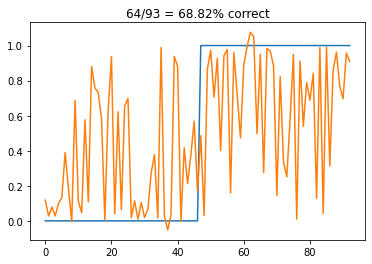

In [102]:
# Get predictions

import matplotlib.pyplot as plt

y = np.array(yTest)
X = test_rest_p_torch
N = len(y)

# pred = np.zeros(N)
# y1 = np.zeros(N) # rmse
# y2 = np.zeros(N) # mae
# for i in range(N):
#     pred[i] = cnn(X[i].unsqueeze(0).unsqueeze(0))[0]
#     y1[i] = (y[i,0]-pred[i])**2
#     y2[i] = abs(y[i,0]-pred[i])

batch = []
for i in range(N):
    batch.append(X[i].unsqueeze(0).unsqueeze(0).cuda())

batch = torch.cat(batch)
pred = fc_conv(batch).view(N).cpu().detach().numpy()

nCorrect = 0
for i in range(N):
    if pred[i] > 0.5 and y[i] > 0.5:
        nCorrect += 1
    if pred[i] < 0.5 and y[i] < 0.5:
        nCorrect += 1

plt.plot(y, label='Truth')
plt.plot(pred, label='Prediction')
plt.title('{:d}/{:d} = {:.2f}% correct'.format(nCorrect, N, nCorrect/N*100))
plt.show()
# y1 = (y.reshape(N)-pred)**2 # rmse
# y2 = abs(y.reshape(N)-pred) # mae
    
# print(np.corrcoef(y, pred))
# print((y1.sum()/N)**0.5/12)
# print(y2.sum()/N/12)
# print(y1)
# print(y2)

# idcs = np.argsort(y,axis=0)
# plt.plot(y[idcs], label='truth')
# plt.plot(pred[idcs], label='prediction')
# plt.legend()
# plt.show()

# plt.scatter(y, pred)
# plt.show()